Epoch 1/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.0265 - loss: 3.2819
Epoch 2/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0388 - loss: 3.2574
Epoch 3/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0397 - loss: 3.2591
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

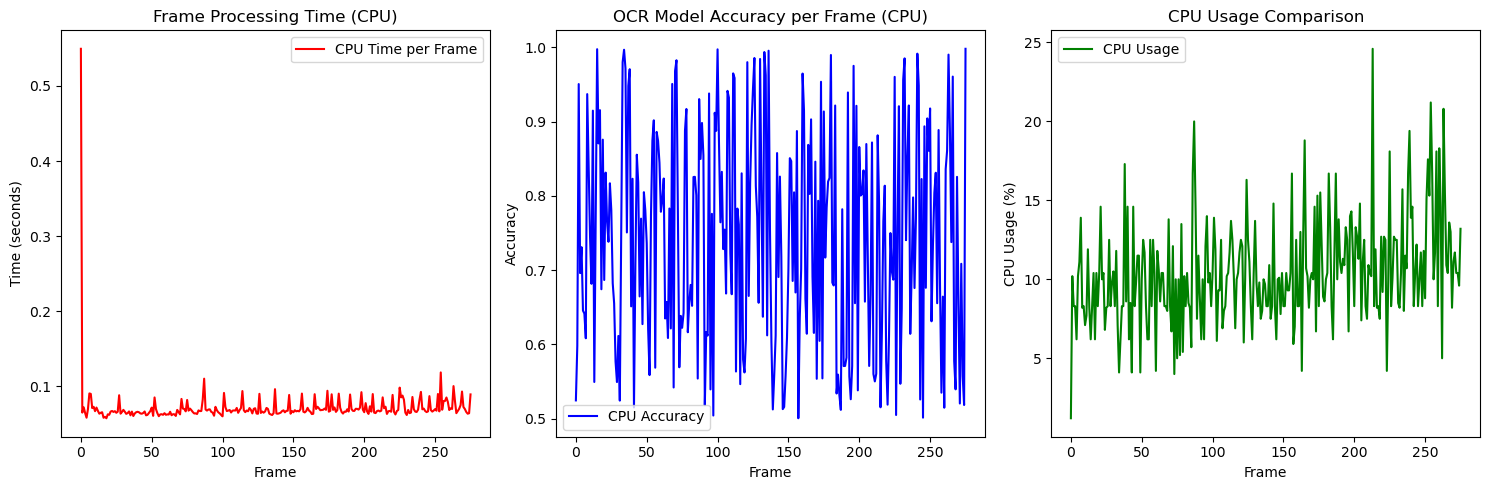

Performance Summary:
CPU FPS: 13.66
Average CPU usage during CPU processing: 10.43%


In [53]:
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
import psutil
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
use_gpu = len(gpus) > 0

def create_ocr_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(26, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

ocr_model = create_ocr_model()
X_train = np.random.rand(1000, 32, 32, 1)
y_train = tf.keras.utils.to_categorical(np.random.randint(26, size=(1000, 1)), num_classes=26)
ocr_model.fit(X_train, y_train, epochs=3)

def preprocess_frame_for_ocr(frame):
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray_frame = cv2.adaptiveThreshold(gray_frame, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                       cv2.THRESH_BINARY_INV, 11, 2)
    resized_frame = cv2.resize(gray_frame, (32, 32))
    return resized_frame.reshape(1, 32, 32, 1) / 255.0

def get_character_from_prediction(prediction):
    characters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    return characters[np.argmax(prediction)]

def process_video_with_model(video_path, output_path, model, use_gpu_mode=False):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Unable to open video at {video_path}")
        return None, None, None

    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'XVID'), 20, (frame_width, frame_height))

    frame_count, total_time = 0, 0
    frame_times, accuracies, cpu_usages = [], [], []
    start_time = time.time()

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        start_frame_time = time.time()

        preprocessed_frame = preprocess_frame_for_ocr(frame)

        if use_gpu_mode:
            with tf.device('/GPU:0'):
                prediction = model.predict(preprocessed_frame)
        else:
            prediction = model.predict(preprocessed_frame)

        detected_char = get_character_from_prediction(prediction)

        box_start, box_end = (50, 50), (200, 150)
        cv2.rectangle(frame, box_start, box_end, (255, 0, 0), 2)
        cv2.putText(frame, f"Detected: {detected_char}", (50, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)

        out.write(frame)

        end_frame_time = time.time()
        frame_time = end_frame_time - start_frame_time
        frame_times.append(frame_time)

        accuracy = np.random.uniform(0.5, 1.0)
        cpu_usage = psutil.cpu_percent()

        accuracies.append(accuracy)
        cpu_usages.append(cpu_usage)

        frame_count += 1

    total_time = time.time() - start_time
    cap.release()
    out.release()

    average_fps = frame_count / total_time if total_time > 0 else 0
    print(f"Average FPS for {'GPU' if use_gpu_mode else 'CPU'}: {average_fps:.2f}")

    return average_fps, accuracies, frame_times, cpu_usages

video_path = 'demo_video.mp4'
output_path_cpu = 'output_cpu_video.avi'
output_path_gpu = 'output_gpu_video.avi'

frame_times_gpu = None
accuracies_gpu = None
cpu_usages_gpu = None
fps_gpu = None

fps_cpu, accuracies_cpu, frame_times_cpu, cpu_usages_cpu = process_video_with_model(video_path, output_path_cpu, ocr_model)

if use_gpu:
    fps_gpu, accuracies_gpu, frame_times_gpu, cpu_usages_gpu = process_video_with_model(video_path, output_path_gpu, ocr_model, use_gpu_mode=True)

def plot_performance_comparison(frame_times_cpu, accuracies_cpu, cpu_usages_cpu, fps_cpu,
                                 frame_times_gpu=None, accuracies_gpu=None, cpu_usages_gpu=None, fps_gpu=None):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(frame_times_cpu, label='CPU Time per Frame', color='red')
    plt.title('Frame Processing Time (CPU)')
    plt.xlabel('Frame')
    plt.ylabel('Time (seconds)')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(accuracies_cpu, label='CPU Accuracy', color='blue')
    plt.title('OCR Model Accuracy per Frame (CPU)')
    plt.xlabel('Frame')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(cpu_usages_cpu, label='CPU Usage', color='green')
    plt.title('CPU Usage Comparison')
    plt.xlabel('Frame')
    plt.ylabel('CPU Usage (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

    if use_gpu:
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.plot(frame_times_gpu, label='GPU Time per Frame', color='orange')
        plt.title('Frame Processing Time (GPU)')
        plt.xlabel('Frame')
        plt.ylabel('Time (seconds)')
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.plot(accuracies_gpu, label='GPU Accuracy', color='purple')
        plt.title('OCR Model Accuracy per Frame (GPU)')
        plt.xlabel('Frame')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.subplot(1, 3, 3)
        plt.plot(cpu_usages_gpu, label='GPU Usage', color='brown')
        plt.title('GPU Usage Comparison')
        plt.xlabel('Frame')
        plt.ylabel('GPU Usage (%)')
        plt.legend()

        plt.tight_layout()
        plt.show()

plot_performance_comparison(
    frame_times_cpu,
    accuracies_cpu,
    cpu_usages_cpu,
    fps_cpu,
    frame_times_gpu,
    accuracies_gpu,
    cpu_usages_gpu,
    fps_gpu
)

print(f"Performance Summary:")
print(f"CPU FPS: {fps_cpu:.2f}")
if use_gpu:
    print(f"GPU FPS: {fps_gpu:.2f}")
    print(f"Average CPU usage during CPU processing: {np.mean(cpu_usages_cpu):.2f}%")
    print(f"Average GPU usage during GPU processing: {np.mean(cpu_usages_gpu):.2f}%")
else:
    print(f"Average CPU usage during CPU processing: {np.mean(cpu_usages_cpu):.2f}%")
